# DVC Dataset Loading Tutorial for Training

This notebook demonstrates how to load datasets managed with DVC for machine learning training.

## Overview
- Load ASR dataset from DVC
- Explore dataset structure
- Get data URLs and paths for training
- Best practices for working with DVC in training pipelines

## 1. Import Dependencies

First, let's import all necessary libraries for working with DVC and datasets.

In [2]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
import subprocess
import yaml

# DVC and Git integration
import dvc.api
import dvc.repo
from dvc.exceptions import DvcException

# Audio processing (for ASR datasets)
import librosa
import soundfile as sf

# Visualization
import matplotlib.pyplot as plt
# import seaborn as sns

# Set up plotting style
plt.style.use('default')
# sns.set_palette("husl")

print("✅ All dependencies imported successfully")
print(f"📁 Current working directory: {os.getcwd()}")

✅ All dependencies imported successfully
📁 Current working directory: /home/franklin/ai/ai_service/training&processes/notebooks/asr


## 2. Configure DVC Repository Path

Set up the path to our DVC repository and target dataset.

In [3]:
# Repository and dataset configuration
REPO_ROOT = "/home/franklin/ai/ai_service"
DATASET_DVC_FILE = "datasets/asr/asr-dataset-v1-2025-07-14.dvc"
DATASET_PATH = "datasets/asr/asr-dataset-v1-2025-07-14"

# Change to repository root for DVC operations
os.chdir(REPO_ROOT)

print(f"📂 Repository root: {REPO_ROOT}")
print(f"📋 Dataset DVC file: {DATASET_DVC_FILE}")
print(f"📁 Dataset path: {DATASET_PATH}")
print(f"✅ Changed working directory to: {os.getcwd()}")

📂 Repository root: /home/franklin/ai/ai_service
📋 Dataset DVC file: datasets/asr/asr-dataset-v1-2025-07-14.dvc
📁 Dataset path: datasets/asr/asr-dataset-v1-2025-07-14
✅ Changed working directory to: /home/franklin/ai/ai_service


## 3. Check DVC Status

Before loading data, let's check the current status of our DVC repository and dataset.

In [4]:
def run_dvc_command(cmd):
    """Helper function to run DVC commands and capture output"""
    try:
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True, cwd=REPO_ROOT)
        return result.stdout, result.stderr, result.returncode
    except Exception as e:
        return "", str(e), 1

# Check DVC status
print("🔍 Checking DVC status...")
stdout, stderr, returncode = run_dvc_command("dvc status")

if returncode == 0:
    if stdout.strip():
        print("📋 DVC Status:")
        print(stdout)
    else:
        print("✅ All DVC files are up to date")
else:
    print(f"❌ DVC status error: {stderr}")

# Check if dataset exists locally
dataset_exists_locally = os.path.exists(DATASET_PATH)
print(f"\n📁 Dataset exists locally: {dataset_exists_locally}")

# Check DVC file
dvc_file_exists = os.path.exists(DATASET_DVC_FILE)
print(f"📋 DVC file exists: {dvc_file_exists}")

🔍 Checking DVC status...
📋 DVC Status:
Data and pipelines are up to date.


📁 Dataset exists locally: True
📋 DVC file exists: True


## 4. Read Dataset Metadata

Let's examine the DVC file to understand our dataset structure and metadata.

In [5]:
# Read DVC file metadata
if dvc_file_exists:
    with open(DATASET_DVC_FILE, 'r') as f:
        dvc_metadata = yaml.safe_load(f)
    
    print("📊 Dataset Metadata from DVC file:")
    print(json.dumps(dvc_metadata, indent=2))
    
    # Extract key information
    if 'outs' in dvc_metadata and len(dvc_metadata['outs']) > 0:
        dataset_info = dvc_metadata['outs'][0]
        
        print(f"\n📈 Dataset Summary:")
        print(f"  • Size: {dataset_info.get('size', 'Unknown'):,} bytes ({dataset_info.get('size', 0) / (1024**2):.1f} MB)")
        print(f"  • Number of files: {dataset_info.get('nfiles', 'Unknown')}")
        print(f"  • MD5 hash: {dataset_info.get('md5', 'Unknown')}")
        print(f"  • Path: {dataset_info.get('path', 'Unknown')}")
else:
    print(f"❌ DVC file not found: {DATASET_DVC_FILE}")

📊 Dataset Metadata from DVC file:
{
  "outs": [
    {
      "md5": "1a520c7d27c392a03c06ff1c86a0d6f0.dir",
      "size": 92710640,
      "nfiles": 247,
      "hash": "md5",
      "path": "asr-dataset-v1-2025-07-14"
    }
  ]
}

📈 Dataset Summary:
  • Size: 92,710,640 bytes (88.4 MB)
  • Number of files: 247
  • MD5 hash: 1a520c7d27c392a03c06ff1c86a0d6f0.dir
  • Path: asr-dataset-v1-2025-07-14


## 5. Pull Dataset from DVC Remote

If the dataset isn't available locally, let's pull it from our DVC remote storage.

In [6]:
# Pull dataset if not available locally
if not dataset_exists_locally:
    print("⬇️ Dataset not found locally. Pulling from DVC remote...")
    
    # Pull specific dataset
    stdout, stderr, returncode = run_dvc_command(f"dvc pull {DATASET_DVC_FILE}")
    
    if returncode == 0:
        print("✅ Dataset pulled successfully!")
        print(stdout)
        dataset_exists_locally = True
    else:
        print(f"❌ Failed to pull dataset: {stderr}")
        print("💡 Make sure you have access to the DVC remote and try: dvc pull")
else:
    print("✅ Dataset already exists locally")

# Verify dataset is now available
if dataset_exists_locally:
    dataset_size = sum(f.stat().st_size for f in Path(DATASET_PATH).rglob('*') if f.is_file())
    file_count = len(list(Path(DATASET_PATH).rglob('*')))
    
    print(f"\n📂 Local Dataset Verification:")
    print(f"  • Total size: {dataset_size:,} bytes ({dataset_size / (1024**2):.1f} MB)")
    print(f"  • Total files: {file_count}")
    print(f"  • Dataset path: {os.path.abspath(DATASET_PATH)}")

✅ Dataset already exists locally

📂 Local Dataset Verification:
  • Total size: 92,710,640 bytes (88.4 MB)
  • Total files: 248
  • Dataset path: /home/franklin/ai/ai_service/datasets/asr/asr-dataset-v1-2025-07-14


## 6. Explore Dataset Structure

Let's explore the structure and contents of our ASR dataset.

In [7]:
if dataset_exists_locally:
    dataset_path = Path(DATASET_PATH)
    
    print("🔍 Dataset Structure:")
    
    # Show directory structure
    def show_tree(path, prefix="", max_items=10):
        """Display directory tree structure"""
        items = list(path.iterdir())
        items.sort(key=lambda x: (x.is_file(), x.name))
        
        for i, item in enumerate(items[:max_items]):
            is_last = i == len(items[:max_items]) - 1
            current_prefix = "└── " if is_last else "├── "
            
            if item.is_file():
                size = item.stat().st_size
                size_str = f" ({size:,} bytes)" if size < 1024*1024 else f" ({size/(1024*1024):.1f} MB)"
                print(f"{prefix}{current_prefix}{item.name}{size_str}")
            else:
                print(f"{prefix}{current_prefix}{item.name}/")
                if len(list(item.iterdir())) > 0:
                    next_prefix = prefix + ("    " if is_last else "│   ")
                    show_tree(item, next_prefix, max_items=5)
        
        if len(items) > max_items:
            print(f"{prefix}... and {len(items) - max_items} more items")
    
    show_tree(dataset_path)
    
    # Analyze file types
    print("\n📊 File Type Analysis:")
    file_types = {}
    total_size_by_type = {}
    
    for file_path in dataset_path.rglob('*'):
        if file_path.is_file():
            ext = file_path.suffix.lower()
            size = file_path.stat().st_size
            
            file_types[ext] = file_types.get(ext, 0) + 1
            total_size_by_type[ext] = total_size_by_type.get(ext, 0) + size
    
    for ext, count in sorted(file_types.items(), key=lambda x: x[1], reverse=True):
        size_mb = total_size_by_type[ext] / (1024*1024)
        avg_size_kb = (total_size_by_type[ext] / count) / 1024
        print(f"  {ext or '(no extension)':>10}: {count:>3} files, {size_mb:>6.1f} MB total, {avg_size_kb:>6.1f} KB avg")
else:
    print("❌ Dataset not available locally. Cannot explore structure.")

🔍 Dataset Structure:
├── audio/
│   ├── chunk_010cc696b5b29812.wav (396,232 bytes)
│   ├── chunk_012c9413def5ba77.wav (392,072 bytes)
│   ├── chunk_016257076b947d1d.wav (381,612 bytes)
│   ├── chunk_0220e1bbd60fb83e.wav (368,652 bytes)
│   └── chunk_051adba386199722.wav (378,860 bytes)
│   ... and 241 more items
└── manifest.jsonl (68,488 bytes)

📊 File Type Analysis:
        .wav: 246 files,   88.4 MB total,  367.8 KB avg
      .jsonl:   1 files,    0.1 MB total,   66.9 KB avg


## 7. Get Data URLs and Paths for Training

This section shows how to get file paths and URLs that can be used in training scripts.

In [8]:
if dataset_exists_locally:
    print("🔗 Dataset Paths and URLs for Training:")
    
    # Method 1: Direct file paths (fastest for local training)
    dataset_abs_path = os.path.abspath(DATASET_PATH)
    print(f"\n📁 Absolute Dataset Path:")
    print(f"  {dataset_abs_path}")
    
    # Method 2: Using DVC API to get file URLs
    print(f"\n🌐 DVC API Methods:")
    
    try:
        # Get file URL using DVC API (works with remotes)
        file_url = dvc.api.get_url(DATASET_PATH, repo=REPO_ROOT)
        print(f"  DVC URL: {file_url}")
    except Exception as e:
        print(f"  DVC URL: Not available ({e})")
    
    # Method 3: List all audio files for training
    print(f"\n🎵 Audio Files for Training:")
    audio_extensions = {'.wav', '.mp3', '.flac', '.ogg', '.m4a'}
    audio_files = []
    
    for file_path in Path(dataset_abs_path).rglob('*'):
        if file_path.is_file() and file_path.suffix.lower() in audio_extensions:
            audio_files.append(str(file_path))
    
    print(f"  Found {len(audio_files)} audio files")
    
    # Show first few audio files
    for i, audio_file in enumerate(audio_files[:5]):
        rel_path = os.path.relpath(audio_file, dataset_abs_path)
        file_size = os.path.getsize(audio_file) / 1024  # KB
        print(f"    {i+1:2d}. {rel_path} ({file_size:.1f} KB)")
    
    if len(audio_files) > 5:
        print(f"    ... and {len(audio_files) - 5} more files")
    
    # Method 4: Create training file list
    print(f"\n📋 Creating Training File Lists:")
    
    # Save audio file list for training
    train_files_list = os.path.join(os.getcwd(), 'audio_files_list.txt')
    with open(train_files_list, 'w') as f:
        for audio_file in audio_files:
            f.write(f"{audio_file}\n")
    
    print(f"  ✅ Audio file list saved to: {train_files_list}")
    print(f"  📊 Total audio files: {len(audio_files)}")
    
    # Look for metadata files
    metadata_files = []
    metadata_extensions = {'.json', '.csv', '.txt', '.tsv', '.yaml', '.yml'}
    
    for file_path in Path(dataset_abs_path).rglob('*'):
        if (file_path.is_file() and 
            file_path.suffix.lower() in metadata_extensions and
            'metadata' in file_path.name.lower() or 'labels' in file_path.name.lower() or 'transcripts' in file_path.name.lower()):
            metadata_files.append(str(file_path))
    
    if metadata_files:
        print(f"\n📄 Metadata Files Found:")
        for metadata_file in metadata_files:
            rel_path = os.path.relpath(metadata_file, dataset_abs_path)
            print(f"    • {rel_path}")
    else:
        print(f"\n📄 No obvious metadata files found (looked for files with 'metadata', 'labels', or 'transcripts' in name)")

else:
    print("❌ Dataset not available. Cannot generate URLs and paths.")

🔗 Dataset Paths and URLs for Training:

📁 Absolute Dataset Path:
  /home/franklin/ai/ai_service/datasets/asr/asr-dataset-v1-2025-07-14

🌐 DVC API Methods:
  DVC URL: ssh://ml-server-local/opt/dvc-storage/files/md5/1a/520c7d27c392a03c06ff1c86a0d6f0.dir

🎵 Audio Files for Training:
  Found 246 audio files
     1. audio/chunk_122d97935d1ceabd.wav (366.0 KB)
     2. audio/chunk_e0840615a6118f90.wav (373.5 KB)
     3. audio/chunk_3884bfe200d03c8f.wav (372.0 KB)
     4. audio/chunk_9aedf480b6324d4c.wav (367.4 KB)
     5. audio/chunk_f930424ec5f23754.wav (380.3 KB)
    ... and 241 more files

📋 Creating Training File Lists:
  ✅ Audio file list saved to: /home/franklin/ai/ai_service/audio_files_list.txt
  📊 Total audio files: 246

📄 No obvious metadata files found (looked for files with 'metadata', 'labels', or 'transcripts' in name)


## 8. Training Integration Examples

Here are practical examples of how to use the loaded dataset in training scripts.

🚀 Training Integration Examples:

1️⃣ Simple File Iteration:
```python
dataset_path = '/home/franklin/ai/ai_service/datasets/asr/asr-dataset-v1-2025-07-14'
for audio_file in os.listdir(dataset_path):
    if audio_file.endswith(('.wav', '.mp3')):
        full_path = os.path.join(dataset_path, audio_file)
        # Load and process audio for training
        audio_data, sr = librosa.load(full_path)
```

2️⃣ Using Generated File List:
```python
with open('/home/franklin/ai/ai_service/audio_files_list.txt', 'r') as f:
    audio_files = [line.strip() for line in f.readlines()]

for audio_file in audio_files:
    audio_data, sr = librosa.load(audio_file)
    # Process for training
```

3️⃣ PyTorch Dataset Class:
```python
from torch.utils.data import Dataset, DataLoader

class ASRDataset(Dataset):
    def __init__(self, file_list):
        with open('/home/franklin/ai/ai_service/audio_files_list.txt', 'r') as f:
            self.audio_files = [line.strip() for line in f.readlines()]
    
   

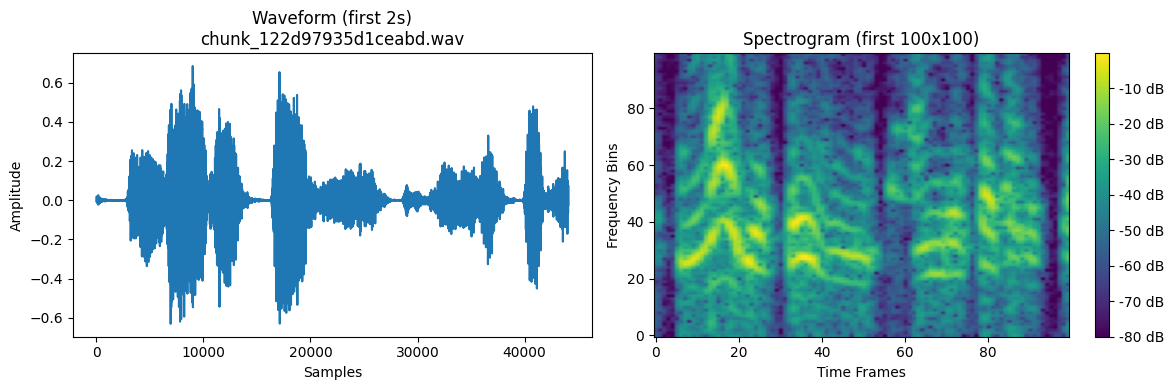

In [9]:
if dataset_exists_locally and len(audio_files) > 0:
    print("🚀 Training Integration Examples:")
    
    # Example 1: Simple file iteration
    print("\n1️⃣ Simple File Iteration:")
    print("```python")
    print(f"dataset_path = '{dataset_abs_path}'")
    print("for audio_file in os.listdir(dataset_path):")
    print("    if audio_file.endswith(('.wav', '.mp3')):")
    print("        full_path = os.path.join(dataset_path, audio_file)")
    print("        # Load and process audio for training")
    print("        audio_data, sr = librosa.load(full_path)")
    print("```")
    
    # Example 2: Using the file list
    print("\n2️⃣ Using Generated File List:")
    print("```python")
    print(f"with open('{train_files_list}', 'r') as f:")
    print("    audio_files = [line.strip() for line in f.readlines()]")
    print("")
    print("for audio_file in audio_files:")
    print("    audio_data, sr = librosa.load(audio_file)")
    print("    # Process for training")
    print("```")
    
    # Example 3: PyTorch Dataset class
    print("\n3️⃣ PyTorch Dataset Class:")
    print("```python")
    print("from torch.utils.data import Dataset, DataLoader")
    print("")
    print("class ASRDataset(Dataset):")
    print("    def __init__(self, file_list):")
    print(f"        with open('{train_files_list}', 'r') as f:")
    print("            self.audio_files = [line.strip() for line in f.readlines()]")
    print("    ")
    print("    def __len__(self):")
    print("        return len(self.audio_files)")
    print("    ")
    print("    def __getitem__(self, idx):")
    print("        audio_path = self.audio_files[idx]")
    print("        audio_data, sr = librosa.load(audio_path)")
    print("        return audio_data, audio_path")
    print("")
    print("# Usage")
    print("dataset = ASRDataset(file_list)")
    print("dataloader = DataLoader(dataset, batch_size=32, shuffle=True)")
    print("```")
    
    # Example 4: Load sample audio
    print("\n4️⃣ Sample Audio Loading:")
    
    sample_file = audio_files[0]
    try:
        # Load a sample audio file
        audio_data, sr = librosa.load(sample_file, duration=5.0)  # Load first 5 seconds
        
        print(f"✅ Successfully loaded sample audio:")
        print(f"   File: {os.path.basename(sample_file)}")
        print(f"   Duration: {len(audio_data)/sr:.2f} seconds")
        print(f"   Sample rate: {sr} Hz")
        print(f"   Shape: {audio_data.shape}")
        print(f"   Data type: {audio_data.dtype}")
        print(f"   Min/Max values: {audio_data.min():.3f} / {audio_data.max():.3f}")
        
        # Simple visualization
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(audio_data[:sr*2])  # First 2 seconds
        plt.title(f'Waveform (first 2s)\n{os.path.basename(sample_file)}')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        
        plt.subplot(1, 2, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
        plt.imshow(D[:100, :100], aspect='auto', origin='lower')
        plt.title('Spectrogram (first 100x100)')
        plt.xlabel('Time Frames')
        plt.ylabel('Frequency Bins')
        plt.colorbar(format='%+2.0f dB')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Could not load sample audio: {e}")
        print("💡 Make sure librosa is installed: pip install librosa")
else:
    print("❌ No audio files available for training examples.")

## 9. Best Practices for DVC in Training

Key recommendations for using DVC datasets in training pipelines.

In [ ]:
print("📚 DVC Training Best Practices:")
print("\n🔧 Development Workflow:")
print("  1. Use 'dvc status' to check data freshness before training")
print("  2. Use 'dvc pull' to get latest dataset versions")
print("  3. Use absolute paths in training scripts for reliability")
print("  4. Save training outputs with DVC for reproducibility")

print("\n⚡ Performance Tips:")
print("  • Use local paths (not DVC URLs) for faster I/O during training")
print("  • Consider dataset caching strategies for large datasets")
print("  • Use 'dvc gc -w' to clean unused cache and save disk space")
print("  • Pull only specific datasets you need: dvc pull path/to/dataset.dvc")

print("\n🔐 Data Versioning:")
print("  • Pin specific dataset versions in training configs")
print("  • Use Git tags/branches to track dataset + code combinations")
print("  • Document dataset versions used in model metadata")

print("\n🚀 Production Deployment:")
print("  • Include DVC pull in your training pipeline setup")
print("  • Use DVC remotes that your training infrastructure can access")
print("  • Consider dataset checksums for data integrity validation")

print("\n💡 Useful DVC Commands for Training:")
commands = {
    "dvc status": "Check if data is up to date",
    "dvc pull dataset.dvc": "Pull specific dataset",
    "dvc add trained_model/": "Version control trained models",
    "dvc push": "Push new model versions to remote",
    "dvc gc -w": "Clean unused cache files",
    "dvc cache dir": "Check cache location and size"
}

for cmd, desc in commands.items():
    print(f"  • {cmd:<20} - {desc}")

# Show current repository status summary
print("\n📊 Current Repository Summary:")
print(f"  • Repository: {REPO_ROOT}")
print(f"  • Dataset: {DATASET_PATH} ({os.path.exists(DATASET_PATH) and 'Available' or 'Not available'})")
print(f"  • Cache size: {run_dvc_command('du -sh .dvc/cache 2>/dev/null || echo "0"')[0].strip()}")
print(f"  • DVC remotes: {len(run_dvc_command('dvc remote list')[0].strip().split('\n')) if run_dvc_command('dvc remote list')[0].strip() else 0}")

## 10. Next Steps

Now you're ready to use this dataset in your training pipeline!

In [ ]:
print("🎯 Next Steps for Training:")

if dataset_exists_locally and len(audio_files) > 0:
    print(f"\n✅ Your dataset is ready for training!")
    print(f"   📁 Dataset path: {dataset_abs_path}")
    print(f"   🎵 Audio files: {len(audio_files)}")
    print(f"   📋 File list: {train_files_list}")
    
    print(f"\n🔥 Quick start training template:")
    print("```python")
    print("# Load your dataset")
    print(f"dataset_path = '{dataset_abs_path}'")
    print("audio_files = glob.glob(os.path.join(dataset_path, '**', '*.wav'), recursive=True)")
    print("")
    print("# Create your training loop")
    print("for epoch in range(num_epochs):")
    print("    for audio_file in audio_files:")
    print("        # Load and process audio")
    print("        audio_data, sr = librosa.load(audio_file)")
    print("        # Your training logic here")
    print("        # ...")
    print("```")
else:
    print(f"\n⚠️ Dataset not available - run the cells above to pull from DVC remote")
    print(f"   Command to run manually: cd {REPO_ROOT} && dvc pull {DATASET_DVC_FILE}")

print(f"\n📚 Additional Resources:")
print(f"  • DVC Documentation: https://dvc.org/doc")
print(f"  • ASR Training Tutorials: https://pytorch.org/tutorials/")
print(f"  • Librosa Documentation: https://librosa.org/doc/")

print(f"\n🎉 Tutorial completed! You now know how to load DVC datasets for training.")